In [1]:
import sys
import os
from pathlib import Path

# Point to insolation_model project root
insolation_root = Path(os.path.dirname(os.path.abspath(""))).resolve()
if str(insolation_root) not in sys.path:
    sys.path.insert(0, str(insolation_root))

import numpy as np

from insolation_model import vis

from insolation_model.geometry.shading import _rad

from tests.conftest import make_dem_with_gradients

In [2]:
def plot_indices(I, J, ax, **kwargs):
    return ax.scatter(J + 0.5, -I - 0.5, **kwargs)

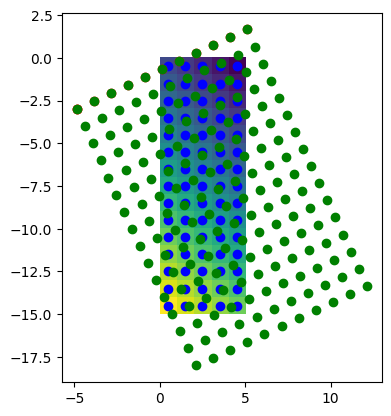

In [18]:
dx = 1
grad_x = -0.1
grad_y = -0.1
n_rows = 15
n_cols = 5
dem = make_dem_with_gradients(grad_x, grad_y, dx, dx, n_rows, n_cols)
vmin, vmax = dem.arr.min(), dem.arr.max()


theta = 25

n_packets = int(np.ceil(n_cols + n_rows * np.sin(_rad(theta)) * np.cos(_rad(theta))))
n_fronts = int(np.ceil(n_rows * np.cos(_rad(theta)) + n_cols * np.sin(_rad(theta))))
alpha = 1
beta = np.tan(_rad(theta))

i0, j0 = (
    (n_rows - 1)
    * np.sin(_rad(theta))
    * np.array([np.sin(_rad(theta)), -np.cos(_rad(theta))])
)
ii0 = i0 - np.arange(n_packets) * beta
jj0 = j0 + np.arange(n_packets) * alpha

di = 1
dj = np.tan(_rad(theta))

# fronts = ((ii0 + k * di, jj0 + k * dj) for k in range(n_fronts))
Fi = np.outer(np.ones(n_fronts), ii0) + np.outer(
    np.arange(n_fronts), np.ones(n_packets) * di
)
Fj = np.outer(np.ones(n_fronts), jj0) + np.outer(
    np.arange(n_fronts), np.ones(n_packets) * dj
)

J, I = np.meshgrid(
    np.linspace(0, n_cols - 1, n_cols), np.linspace(0, n_rows - 1, n_rows)
)


ax = vis.raster(dem)
plot_indices(I, J, ax, color="blue")
plot_indices(ii0, jj0, ax, color="red")
plot_indices(i0, j0, ax, color="red")


ii = ii0
jj = jj0

for ii, jj in zip(Fi, Fj):
    plot_indices(ii, jj, ax, color="green")

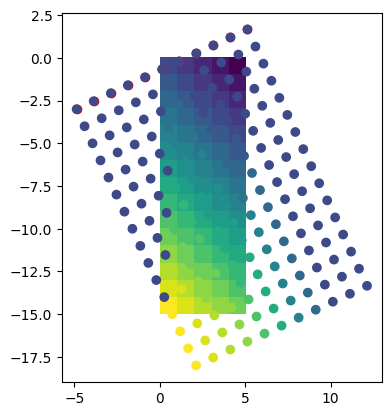

In [22]:
rows = np.clip(Fi.astype(int), 0, dem.arr.shape[0] - 1)
cols = np.clip(Fj.astype(int), 0, dem.arr.shape[1] - 1)
values = dem.arr[rows, cols]
valid = (Fi >= 0) & (Fj >= 0) & (Fi < n_rows) & (Fj < n_cols)
values[~valid] = 0
cummax = np.maximum.accumulate(values, axis=0)

ax = vis.raster(dem, vmin=vmin, vmax=vmax)
# plot_indices(I, J, ax, color="blue")
plot_indices(ii0, jj0, ax, color="red")
plot_indices(Fi, Fj, ax, c=cummax, vmin=vmin, vmax=vmax)